# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP1-ML-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

**Data**
You will have at your disposal the ISIC 2017 dataset (https://challenge.isic-archive.com/data/#2017) already pre-processed, resized and quality checked. It is divided into Training (N=2000), Validation (N=150) and Test (N=600) sets.

**Goal**
The goal of this practical session is to classify images of skin lesions as either benign (nevus or seborrheic_keratosis) or melanoma (binary classification) using machine and deep learning algorithms.

In the first part of the TP, you will manually compute some features relevant to the skin lesion classification (feature engineering) and then classify images using "classical" ML algorithms such as, logistic regression, SVM and Random Forests.

In the second part, you will test the features learnt with Deep Learning algorithms. You will first train from scratch well-known CNN architectures (VGG, ResNet, DenseNet, etc..) and then leverage the representations learnt by these networks on a pre-training from Imagenet (fine-tuning, full-restimation).

Please complete the code where you see **"XXXXXXXXX"** and answer the **Questions**


# Feature Engineering

Many features have been proposed for Skin lesion classification. Among the most used ones, there is the so-called ABCD rule whose features describie four important characteristics of the skin lesion: Asymmetry, Border irregularity, Colour(and Texture) and Dimension (and Geometry).

To compute these features, you will have at your disposal the *manual segmentation* of the skin lesions and you could follow, for instance, *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

Other works can be found in the literature.

For the ML part, you can use the CPU server (no need for GPU here)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Representation Learning for Computer Vision and Medical Imaging/TP-1/tp1/data

/content/drive/MyDrive/Representation Learning for Computer Vision and Medical Imaging/TP-1/tp1/data


In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize
from skimage import color
from skimage import measure
from skimage import transform
from skimage.color import rgb2gray
from scipy import ndimage
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import torch
import glob
import cv2
from PIL import Image


%matplotlib inline

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
except:
  IN_COLAB = False

You can either download the data from my Google Drive or work locally.

In [ ]:
if IN_COLAB:
  print("you are using google colab")
  import gdown
#   !mkdir ./data
#   gdown.download(id="1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ", output='./data/TrainCropped.zip', quiet=False)
#   !unzip -qu "./data/TrainCropped.zip" -d "./data"
#   gdown.download(id="1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM", output='./data/TestCropped.zip', quiet=False)
#   !unzip -qu "./data/TestCropped.zip" -d "./data"
#   gdown.download(id="1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb", output='./data/ValCropped.zip', quiet=False)
#   !unzip -qu "./data/ValCropped.zip" -d "./data"
#   !rm -rf ./data/TrainCropped.zip
#   !rm -rf ./data/TestCropped.zip
#   !rm -rf ./data/ValCropped.zip
#   path='./data/'
# else:
#   print('You are NOT using colab')
#   # we assume that folders of data are in the same folder as this jupyter notebook
#   path='' # if you change this path , you should also change idTRain, idVal and idTest


you are using google colab


If there is an error (might happen with gdown) please upload the three files manually.
Follow the following instructions:
- go to the folder symbol on the left of your screen
- click on the three vertical dots on the 'data' folder
- upload (importer in french) the three folders
That's it !

In [ ]:
# if IN_COLAB:
#   !unzip -qu "./data/TrainCropped.zip" -d "./data"
#   !unzip -qu "./data/TestCropped.zip" -d "./data"
#   !unzip -qu "./data/ValCropped.zip" -d "./data"
#   !rm -rf ./data/TrainCropped.zip
#   !rm -rf ./data/TestCropped.zip
#   !rm -rf ./data/ValCropped.zip
#   path='./data/'

Let's load the data.

In [ ]:
path='./'
pathTrain=glob.glob(path + "TrainCropped/*.jpg")
print(pathTrain)
idTrain=np.copy(pathTrain)
if IN_COLAB:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][20:-4]
else:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][13:-4]
#print(idTrain)
print('There are', len(idTrain), 'Train images')

['./TrainCropped/ISIC_0012268.jpg', './TrainCropped/ISIC_0013610.jpg', './TrainCropped/ISIC_0000491.jpg', './TrainCropped/ISIC_0000485.jpg', './TrainCropped/ISIC_0002251.jpg', './TrainCropped/ISIC_0000320.jpg', './TrainCropped/ISIC_0014433.jpg', './TrainCropped/ISIC_0014341.jpg', './TrainCropped/ISIC_0011211.jpg', './TrainCropped/ISIC_0013360.jpg', './TrainCropped/ISIC_0011205.jpg', './TrainCropped/ISIC_0008998.jpg', './TrainCropped/ISIC_0000297.jpg', './TrainCropped/ISIC_0012693.jpg', './TrainCropped/ISIC_0013599.jpg', './TrainCropped/ISIC_0000283.jpg', './TrainCropped/ISIC_0008807.jpg', './TrainCropped/ISIC_0010090.jpg', './TrainCropped/ISIC_0000532.jpg', './TrainCropped/ISIC_0012877.jpg', './TrainCropped/ISIC_0014547.jpg', './TrainCropped/ISIC_0011359.jpg', './TrainCropped/ISIC_0010047.jpg', './TrainCropped/ISIC_0012888.jpg', './TrainCropped/ISIC_0000254.jpg', './TrainCropped/ISIC_0010053.jpg', './TrainCropped/ISIC_0000240.jpg', './TrainCropped/ISIC_0000268.jpg', './TrainCropped/ISI

In [ ]:
pathVal=glob.glob(path + "ValCropped/*.jpg")
idVal=np.copy(pathVal)
if IN_COLAB:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][18:-4]
else:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][11:-4]
# print(idVal)
print('There are', len(idVal) , 'Validation images')

There are 150 Validation images


In [ ]:
pathTest=glob.glob(path + "TestCropped/*.jpg")
idTest=np.copy(pathTest)
if IN_COLAB:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][19:-4]
else:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][12:-4]
#print(idTest)
print('There are', len(idTest) , 'Test images')

There are 600 Test images


We can then plot an image with the related mask and contour.

Text(0.5, 1.0, 'Image with mask')

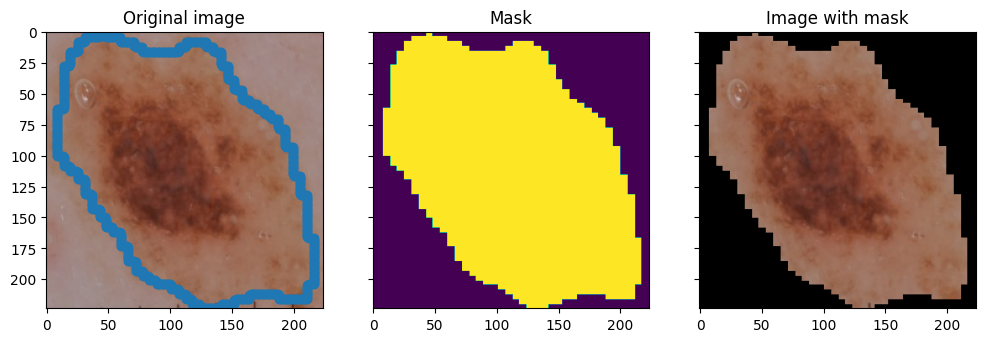

In [ ]:
name_im = 'ISIC_0013896'
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
image_Segmentation_boolean = (image_Segmentation/255).astype(np.uint8) # To get uint16
image_Segmentation_expand = np.expand_dims(image_Segmentation_boolean, axis=2)
image_mul_mask = (image_Segmentation_expand*image)
contours = cv2.findContours(image_Segmentation_boolean, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contour = list(contours[0])
contour = np.squeeze(np.asarray(contour))

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(image)
grid[0].scatter(contour[:,0],contour[:,1])
#grid[0].axis('off')
grid[0].set_title("Original image")

grid[1].imshow(image_Segmentation_boolean)
#grid[1].axis('off')
grid[1].set_title("Mask")

grid[2].imshow(image_mul_mask)
#grid[2].axis('off')
grid[2].set_title("Image with mask")

##Manual Feature Engineering

In this part, you will have to manually compute features relevant to the skin lesion classification. You can, for instance, implement the features described in [1] or in other papers.

**TODO**: Implement at least 10 features belonging to at least 3 classes of the ABCD rule, namely:
- Asymmetry
- Border
- Color (and Texture)
- Dimension (and Geometry)

**Please note the overall time (reading papers + implementation + computation) for computing the features. You will need it in the next part of the practical session.**

**This part counts for half of the grade of this TP**

[1] M. Zortea et al. "Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists". Artificial Intelligence in Medicine. 2014

### Asymmetry of shape (2 features)

In [ ]:
def calculate_center_of_mass(mask):
    moments = cv2.moments(mask)
    cx = int(moments["m10"] / moments["m00"])
    cy = int(moments["m01"] / moments["m00"])
    return cx, cy

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def calculate_asymmetry(image, mask):
    cx, cy = calculate_center_of_mass(mask)
    rows, cols = image.shape
    best_S1, best_S2 = float('inf'), float('inf')
    best_angle = 0

    for angle in range(0, 90, 10):
        rotated_image = rotate_image(image, angle)
        rotated_mask = rotate_image(mask, angle)

        S1, S2 = 0, 0
        for i in range(rows):
            for j in range(cols):
                if rotated_mask[i, j] > 0:
                    if j < cx:
                        S1 += abs(rotated_image[i, j] - rotated_image[i, cols - 1 - j])
                    if i < cy:
                        S2 += abs(rotated_image[i, j] - rotated_image[rows - 1 - i, j])

        area = np.sum(rotated_mask > 0)
        S1 /= area
        S2 /= area
        # We retain the rotation with the lowest average scores of S1 and S2
        if S1 + S2 < best_S1 + best_S2:
            best_S1, best_S2 = S1, S2
            best_angle = angle

    return best_S1, best_S2, best_angle

In [ ]:
def draw_axes_on_image(image, mask, angle):
    cx, cy = calculate_center_of_mass(mask)
    rows, cols = image.shape[:2]

    # Create a copy of the image to draw on
    image_with_axes = image.copy()

    # Drawing the contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image_with_axes, contours, -1, (0, 0, 255), 2)  # red contour
    # Calculating the end points for the axes
    length = max(rows, cols)
    x_axis_endpoints = ((cx - length, cy), (cx + length, cy))
    y_axis_endpoints = ((cx, cy - length), (cx, cy + length))

    # Rotating the endpoints
    rot_mat = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    x_axis_endpoints = cv2.transform(np.array([x_axis_endpoints]), rot_mat)[0]
    y_axis_endpoints = cv2.transform(np.array([y_axis_endpoints]), rot_mat)[0]

    # Drawing the axes
    cv2.line(image_with_axes, tuple(x_axis_endpoints[0]), tuple(x_axis_endpoints[1]), (255, 0, 0), 2)
    cv2.line(image_with_axes, tuple(y_axis_endpoints[0]), tuple(y_axis_endpoints[1]), (0, 255, 0), 2)

    # Display the image
    plt.imshow(image_with_axes)
    plt.show()


Feature 1 (Asymmetry S1): 0.04556560087830413, Feature 2 (Asymmetry S2): 0.030161817463746635, angle 0


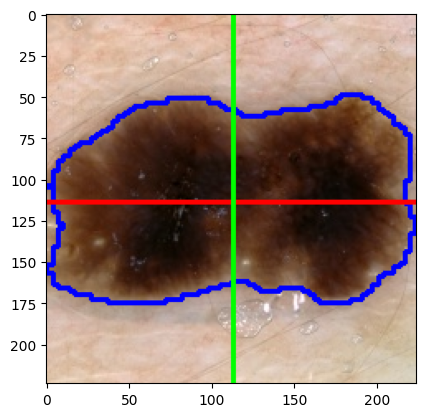

In [ ]:
name_im = 'ISIC_0015260'
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
mask = (image_Segmentation/255).astype(np.uint8) # To get uint16

grayscale_image = rgb2gray(image)
f1, f2,best_angle = calculate_asymmetry(grayscale_image, mask)
print(f"Feature 1 (Asymmetry S1): {f1}, Feature 2 (Asymmetry S2): {f2}, angle {best_angle}")

draw_axes_on_image(image, mask, best_angle)

### Asymmetry of color intensity, computed in gray-scale (2 features)

In [ ]:
def kde_for_region(region_mask):
  values = region_mask.flatten()
  kde = gaussian_kde(values)
  return kde(np.linspace(0, 255, 256))

def calculate_color_asymmetry(image, mask):

    best_C1, best_C2 = float('inf'), float('inf')
    best_angle = 0
    cx, cy = calculate_center_of_mass(mask)
    rows, cols = image.shape[1::-1]

    for angle in range(0, 90, 10):
        rotated_mask = rotate_image(image, angle)
        C1, C2 = 0, 0
        M = rotated_mask.shape[0]//2
        N = rotated_mask.shape[1]//2
        mask_A1, mask_A2, mask_A3, mask_A4 = [rotated_mask[x:x+M,y:y+N] for x in range(0,rotated_mask.shape[0],M) for y in range(0,rotated_mask.shape[1],N)]

        kde_A1_A2 = kde_for_region(mask_A1 | mask_A2)
        kde_A3_A4 = kde_for_region(mask_A3 | mask_A4)
        C1 = np.sum(np.abs(kde_A1_A2 - kde_A3_A4))

        kde_A1_A4 = kde_for_region(mask_A1 | mask_A4)
        kde_A2_A3 = kde_for_region(mask_A2 | mask_A3)
        C2 = np.sum(np.abs(kde_A1_A4 - kde_A2_A3))

        if C1 + C2 < best_C1 + best_C2:
            best_C1, best_C2 = C1, C2
            best_angle = angle

    return best_C1, best_C2, best_angle


In [ ]:
name_im = 'ISIC_0014763'
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
mask = (image_Segmentation/255).astype(np.uint8) # To get uint16
# plt.imshow(image)
# plt.plot()

Feature 3 (Asymmetry C1): 0.14818846822415027, Feature 4 (Asymmetry C2): 0.22774502940224575, angle 0


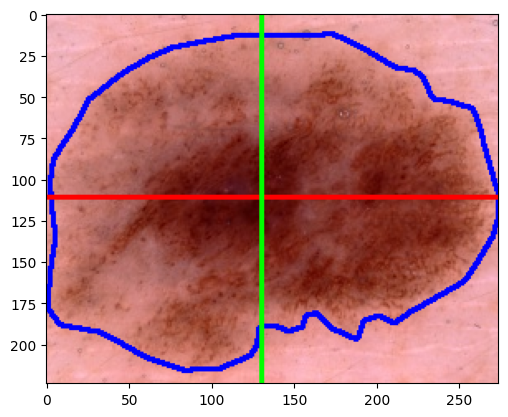

In [ ]:
grayscale_image = rgb2gray(image)
f3, f4,best_angle = calculate_color_asymmetry(image, mask)
print(f"Feature 3 (Asymmetry C1): {f3}, Feature 4 (Asymmetry C2): {f4}, angle {best_angle}")

draw_axes_on_image(image, mask, best_angle)

### Colors, full lesion (3 features)  

In [ ]:
def calculate_lab_features(image, mask):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

    lesion_pixels = lab_image[mask > 0]
    if len(lesion_pixels.flatten()) > 10000:
        chosen_pixels = lesion_pixels[np.random.choice(lesion_pixels.flatten(), 10000, replace=False)]
    else:
        chosen_pixels = lesion_pixels

    # retransform
    chosen_pixels=np.array(chosen_pixels, dtype=float)
    chosen_pixels[:,0] /= 2.55
    chosen_pixels[:,1:] -= 128
    # for i in range(3): print(i, np.min(chosen_pixels[:,i]), np.max(chosen_pixels[:,i]))

    hist, _ = np.histogramdd(chosen_pixels, bins=(50,127,127),range=((0,100),(-127,127),(-127,127)))
    non_empty_bins = hist > 0
    # print(hist.shape)

    f10 = np.mean(hist[non_empty_bins])
    f11 = np.var(hist[non_empty_bins])
    f12 = np.sum(non_empty_bins) / non_empty_bins.size

    return f10, f11, f12


In [ ]:
name_im = 'ISIC_0014763'
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
mask = (image_Segmentation/255).astype(np.uint8) # To get uint16

In [ ]:
f1,f2,f3 = calculate_lab_features(image, mask)
print(f1,f2,f3)

151.5151515151515 72548.73461891644 8.184016368032736e-05


### Border, ANOVA-based analysis (3 features)

In [ ]:
import cv2
from scipy.ndimage import measurements

def calculate_anova_border_features(grayscale, mask):
    # returns the coordinates of all the pixels inside the lesion
    y_coords, x_coords = np.where(mask > 0)

    R_values = []
    window_size = 61  # 61x61 pixels window

    # for every pixel inside
    for y, x in zip(y_coords, x_coords):
        # Define window boundaries
        size = window_size // 2
        x_min, x_max = max(0, x - size), min(mask.shape[1], x + size)
        y_min, y_max = max(0, y - size), min(mask.shape[0], y + size)

        # Window slices
        window = grayscale[y_min:y_max, x_min:x_max]
        window_mask = mask[y_min:y_max, x_min:x_max]

        # Inside and outside pixels
        inside = window[window_mask > 0].flatten()
        outside = window[window_mask == 0].flatten()

        # ANOVA calculations
        if inside.size > 0 and outside.size > 0:
            X = np.concatenate([inside, outside])
            X_bar = np.mean(X)
            SST = np.sum((X - X_bar) ** 2)
            SSE = np.sum((X - np.mean(inside)) ** 2) + np.sum((X - np.mean(outside)) ** 2)
            Rk = SSE / SST if SST != 0 else 0
            R_values.append(Rk)
    # plot the histogram
    # plt.hist(R_values, bins=50, color='blue', edgecolor='black')
    # plt.xlabel('SSE/SST Ratio')
    # plt.ylabel('Number of Border Pixels')
    # plt.title('Histogram of SSE/SST Ratios for Border Pixels')
    # plt.show()
    # Calculate percentiles
    f7 = np.percentile(R_values, 25) if R_values else 0
    f8 = np.percentile(R_values, 50) if R_values else 0
    f9 = np.percentile(R_values, 75) if R_values else 0

    return f7, f8, f9


Test of the ANOVA border feature extraction

In [ ]:
name_im = 'ISIC_0014507'
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
mask = (image_Segmentation/255).astype(np.uint8)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
f7,f8,f9 = calculate_anova_border_features(grayscale,mask)
print(f7,f8,f9)

3.393727529601763 3.801915112762434 4.687693708499699


### Geometric (3 features)


In [ ]:
from skimage.morphology import opening, disk

def pieces_count(threshold, grayscale):
    _, thresh_image = cv2.threshold(grayscale, threshold, 255, cv2.THRESH_BINARY)
    image_open = opening(thresh_image, disk(5))
    contours, _ = cv2.findContours(image_open, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    return image_open, len(contours)

def geometric_feature(grayscale_image, mask):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    lesion_grayscale = grayscale_image[mask > 0]

    p25 =  np.percentile(lesion_grayscale,25)
    p50 =  np.percentile(lesion_grayscale,50)
    p75 =  np.percentile(lesion_grayscale,75)

    image_open1,f21 = pieces_count(p25, grayscale_image)
    image_open2,f22 = pieces_count(p50, grayscale_image)
    image_open3,f23 = pieces_count(p75, grayscale_image)

    # fig = plt.figure(figsize=(12, 12))
    # grid = AxesGrid(fig, 111,
    #                 nrows_ncols = (1, 3),
    #                 axes_pad = 0.5)
    # grid[0].imshow(image_open1, cmap='gray')
    # grid[1].imshow(image_open2, cmap='gray')
    # grid[2].imshow(image_open3, cmap='gray')
    # print(p25,p50,p75)

    return f21,f22,f23


In [ ]:
f21, f22, f23 = geometric_feature(image,mask)
print(f21, f22, f23)

1 2 4


## Loading Metadata and Target values

You have at your disposal also two metadata, the age and the sex. If you want, you can use them as features in the classification but be careful ! There are missing values

We also load the target values (0 for benign and 1 for melanoma)

In [ ]:
!pwd

/content/drive/MyDrive/Representation Learning for Computer Vision and Medical Imaging/TP-1/tp1


In [ ]:
path = './data/'

In [ ]:
%cd tp1

/content/drive/MyDrive/Representation Learning for Computer Vision and Medical Imaging/TP-1/tp1


In [ ]:
Metatrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Data_metadata.csv')
print(Metatrain.head(10))
Groundtrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Part3_GroundTruth.csv')

       image_id age_approximate     sex
0  ISIC_0000000              55  female
1  ISIC_0000001              30  female
2  ISIC_0000002              60  female
3  ISIC_0000003              30    male
4  ISIC_0000004              80    male
5  ISIC_0000006              25  female
6  ISIC_0000007              25  female
7  ISIC_0000008              30  female
8  ISIC_0000009              30  female
9  ISIC_0000010              35  female


In [ ]:
Metatrain.dropna()

,image_id,age_approximate,sex
0,ISIC_0000000,55,female
1,ISIC_0000001,30,female
2,ISIC_0000002,60,female
3,ISIC_0000003,30,male
4,ISIC_0000004,80,male
...,...,...,...
1995,ISIC_0015220,75,male
1996,ISIC_0015233,60,male
1997,ISIC_0015260,55,female
1998,ISIC_0015284,75,male


In [ ]:
Ytrain=np.zeros(len(idTrain))
for i in range(len(idTrain)):
  name=idTrain[i]
  index=Groundtrain["image_id"].str.find(name)
  max_index = index.argmax()
  Ytrain[i]=int(Groundtrain["melanoma"][max_index])

In [ ]:
Metaval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Data_metadata.csv')
Groundval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Part3_GroundTruth.csv')

In [ ]:
Yval=np.zeros(len(idVal))
for i in range(len(idVal)):
  name=idVal[i]
  index=Groundval["image_id"].str.find(name)
  max_index = index.argmax()
  Yval[i]=int(Groundval["melanoma"][max_index])

In [ ]:
Metatest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Data_metadata.csv')
Groundtest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [ ]:
Ytest=np.zeros(len(idTest))
for i in range(len(idTest)):
  name=idTest[i]
  index=Groundtest["image_id"].str.find(name)
  max_index = index.argmax()
  Ytest[i]=int(Groundtest["melanoma"][max_index])

## Standard Machine Learning Prediction

In this part, you will use standard ML algorithms (such as logistic regression, SVM and Random Forests) on the features you previously computed.
Before starting, you should look at the data and check the proportion of classes.
Two hints:
- in sklearn you can use *class_weight='balanced'* when calling a ML method
- it exists a very interesting library called *imblearn* (e.g., from imblearn.over_sampling import ADASYN)

In [ ]:
np.random.seed(seed=666)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

**Pre-trained features**: for the next part, you can either use your own features or download a pre-computed set of features.

In [ ]:
labels=['f1_asym','f2_asym','f5_asym','f6_asym','f7_bord','f8_bord','f9_bord','f10_color','f11_color','f12_color','f13_color','f14_color','f15_color','f16_color','f17_color','f18_color','meanR','stdR','meanG','stdG','meanB','stdB','maxR','maxG','maxB','Area','Ecc','Diam','Ratio','Perim','f21_geom','f22_geom','f23_geom']

In [ ]:
# !mkdir ./data
gdown.download(id="1ELg93G9jHeJOhCGBZ35HFs3NZr5Inj_j", output='./data/X_train_eng.npy', quiet=False)
train_computation_time=115 # in minute

Downloading...
From: https://drive.google.com/uc?id=1ELg93G9jHeJOhCGBZ35HFs3NZr5Inj_j
To: /content/drive/MyDrive/Representation Learning for Computer Vision and Medical Imaging/TP-1/tp1/data/X_train_eng.npy
100%|██████████| 528k/528k [00:00<00:00, 94.3MB/s]


In [ ]:
gdown.download(id="10sr56q1CEro7HPgQjYo0eVniGNA5og5H", output='./data/X_val_eng.npy', quiet=False)
test_computation_time=12 # in minute

Downloading...
From: https://drive.google.com/uc?id=10sr56q1CEro7HPgQjYo0eVniGNA5og5H
To: /content/drive/MyDrive/Representation Learning for Computer Vision and Medical Imaging/TP-1/tp1/data/X_val_eng.npy
100%|██████████| 39.7k/39.7k [00:00<00:00, 20.6MB/s]


In [ ]:
# !mkdir ./data
gdown.download(id="1RbONb3WyG-CGt6SSi124TSXfkiCzb6-D", output='./data/X_test_eng.npy', quiet=False)
test_computation_time=38 # in minute

Downloading...
From: https://drive.google.com/uc?id=1RbONb3WyG-CGt6SSi124TSXfkiCzb6-D
To: /content/drive/MyDrive/Representation Learning for Computer Vision and Medical Imaging/TP-1/tp1/data/X_test_eng.npy
100%|██████████| 159k/159k [00:00<00:00, 50.1MB/s]


In [ ]:
Xtrain=np.load('./data/X_train_eng.npy')
Xtest=np.load('./data/X_test_eng.npy')
Xval=np.load('./data/X_val_eng.npy')

N,M=Xtrain.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(Ytrain), np.sum(Ytrain)))

Number of images: 2000; Number of features per image: 33
Number of healthy nevus: 1626.0; Number of melanoma: 374.0


In [ ]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(Xtrain_scaled, Ytrain)

# Support Vector Machine
svm = SVC(class_weight='balanced')
svm.fit(Xtrain_scaled, Ytrain)

# Random Forest
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(Xtrain_scaled, Ytrain)

RandomForestClassifier(class_weight='balanced')

In [ ]:
Xtest_scaled = scaler.transform(Xtest)
log_reg_preds = log_reg.predict(Xtest_scaled)
log_reg_accuracy = accuracy_score(Ytest, log_reg_preds)
svm_preds = svm.predict(Xtest_scaled)
svm_accuracy = accuracy_score(Ytest, svm_preds)
rf_preds = rf.predict(Xtest_scaled)
rf_accuracy = accuracy_score(Ytest, svm_preds)


In [ ]:
print(f"Accuracy of Logistic Regression on the predefined dataset: {log_reg_accuracy}")
print(f"Accuracy of SVM on the predefined dataset: {svm_accuracy}")
print(f"Accuracy of Random Forest on the predefined dataset: {rf_accuracy}")

Accuracy of Logistic Regression on the predefined dataset: 0.465
Accuracy of SVM on the predefined dataset: 0.6333333333333333
Accuracy of Random Forest on the predefined dataset: 0.6333333333333333


#### Create data frame features

In [ ]:
Metatrain['age_approximate'] = pd.to_numeric(Metatrain['age_approximate'], errors='coerce')
average_age = Metatrain['age_approximate'].mean()
Metatrain['age_approximate'].fillna(average_age, inplace=True)

most_common_gender = Metatrain['sex'].replace('unknown', pd.NA).mode()[0]
Metatrain['sex'].replace('unknown', most_common_gender, inplace=True)
Metatrain['sex'] = Metatrain['sex'].replace({'female': 1, 'male': 0})
print(Metatrain)

          image_id  age_approximate  sex
0     ISIC_0000000             55.0    1
1     ISIC_0000001             30.0    1
2     ISIC_0000002             60.0    1
3     ISIC_0000003             30.0    0
4     ISIC_0000004             80.0    0
...            ...              ...  ...
1995  ISIC_0015220             75.0    0
1996  ISIC_0015233             60.0    0
1997  ISIC_0015260             55.0    1
1998  ISIC_0015284             75.0    0
1999  ISIC_0015295             70.0    0

[2000 rows x 3 columns]


In [ ]:
data = []
for index, row in Metatrain.iterrows():
  name_im = row.image_id
  print(name_im)
  filename = path + 'TrainCropped/{}.jpg'.format(name_im)
  image = imread(filename)
  filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
  image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
  mask = (image_Segmentation/255).astype(np.uint8) # To get uint16
  grayscale_image = rgb2gray(image)
  f1, f2,_ = calculate_asymmetry(grayscale_image, mask)
  # f3, f4,_ = calculate_color_asymmetry(image, mask)
  f5,f6,f7 = calculate_lab_features(image, mask)
  f8,f9,f10 = calculate_anova_border_features(grayscale_image, mask)
  f21, f22, f23 = geometric_feature(image,mask)
  data.append([f1,f2,f5,f6,f7,f8,f9,f10,f21,f22,f23,row.age_approximate,row.sex])

ISIC_0000000
ISIC_0000001
ISIC_0000002
ISIC_0000003
ISIC_0000004
ISIC_0000006
ISIC_0000007
ISIC_0000008
ISIC_0000009
ISIC_0000010
ISIC_0000011
ISIC_0000012
ISIC_0000013
ISIC_0000014
ISIC_0000015
ISIC_0000016
ISIC_0000017
ISIC_0000018
ISIC_0000019
ISIC_0000020
ISIC_0000021
ISIC_0000022
ISIC_0000023
ISIC_0000024
ISIC_0000025
ISIC_0000026
ISIC_0000027
ISIC_0000028
ISIC_0000029
ISIC_0000030
ISIC_0000031
ISIC_0000032
ISIC_0000034
ISIC_0000035
ISIC_0000036
ISIC_0000037
ISIC_0000038
ISIC_0000039
ISIC_0000040
ISIC_0000041
ISIC_0000042
ISIC_0000043
ISIC_0000044
ISIC_0000045
ISIC_0000046
ISIC_0000047
ISIC_0000048
ISIC_0000049
ISIC_0000050
ISIC_0000051
ISIC_0000052
ISIC_0000053
ISIC_0000054
ISIC_0000055
ISIC_0000056
ISIC_0000057
ISIC_0000059
ISIC_0000061
ISIC_0000062
ISIC_0000063
ISIC_0000064
ISIC_0000065
ISIC_0000066
ISIC_0000067
ISIC_0000068
ISIC_0000069
ISIC_0000071
ISIC_0000072
ISIC_0000073
ISIC_0000074
ISIC_0000075
ISIC_0000077
ISIC_0000078
ISIC_0000079
ISIC_0000080
ISIC_0000081
ISIC_0000082

In [ ]:
X_train = pd.DataFrame(data, columns=['f1', 'f2','f5','f6','f7','f8','f9','f10','f21','f22','f23','age','sex'])

In [ ]:
X_train

,f1,f2,f5,f6,f7,f8,f9,f10,f21,f22,f23,age,sex
0,0.034937,0.060278,192.307692,125419.174556,0.000064,3.781331,4.708269,7.153138,1,1,1,55.0,1
1,0.020271,0.032028,322.580645,183124.630593,0.000038,3.902945,4.676157,6.980351,1,1,1,30.0,1
2,0.050525,0.040309,140.845070,54207.454870,0.000088,3.564138,4.211180,5.750614,1,1,1,60.0,1
3,0.064315,0.050189,256.410256,160754.088100,0.000048,3.943021,4.829205,7.608681,1,1,1,30.0,0
4,0.052378,0.062343,120.481928,24274.370155,0.000103,3.862246,5.341490,9.110646,3,4,5,80.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.044951,0.056211,161.290323,79464.077003,0.000077,3.268682,3.785422,4.619399,5,4,10,75.0,0
1996,0.063700,0.042187,322.580645,177643.275754,0.000038,3.191686,3.556940,4.377756,1,1,3,60.0,0
1997,0.045566,0.030162,169.491525,198052.995691,0.000073,3.838168,4.833451,6.783994,1,1,1,55.0,1
1998,0.056866,0.118512,188.679245,82104.217871,0.000066,2.424277,3.353186,4.774801,2,2,2,75.0,0


### Create the test set dataframe

In [ ]:
Metatest['age_approximate'] = pd.to_numeric(Metatest['age_approximate'], errors='coerce')
average_age = Metatest['age_approximate'].mean()
Metatest['age_approximate'].fillna(average_age, inplace=True)

most_common_gender = Metatest['sex'].replace('unknown', pd.NA).mode()[0]
Metatest['sex'].replace('unknown', most_common_gender, inplace=True)
Metatest['sex'] = Metatest['sex'].replace({'female': 1, 'male': 0})
print(Metatest)

         image_id  age_approximate  sex
0    ISIC_0012086             30.0    0
1    ISIC_0012092             40.0    0
2    ISIC_0012095             25.0    0
3    ISIC_0012134             75.0    1
4    ISIC_0012136             70.0    0
..            ...              ...  ...
595  ISIC_0016068             70.0    0
596  ISIC_0016069             30.0    1
597  ISIC_0016070             65.0    0
598  ISIC_0016071             60.0    1
599  ISIC_0016072             65.0    1

[600 rows x 3 columns]


In [ ]:
dataTest = []
for index, row in Metatest.iterrows():
  name_im = row.image_id
  print(name_im)
  filename = path + 'TestCropped/{}.jpg'.format(name_im)
  image = imread(filename)
  filename_Segmentation = path + 'TestCropped/{}seg.png'.format(name_im)
  image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
  mask = (image_Segmentation/255).astype(np.uint8) # To get uint16
  grayscale_image = rgb2gray(image)
  f1, f2,_ = calculate_asymmetry(grayscale_image, mask)
  # f3, f4,_ = calculate_color_asymmetry(image, mask)
  f5,f6,f7 = calculate_lab_features(image, mask)
  f8,f9,f10 = calculate_anova_border_features(grayscale_image, mask)
  f21, f22, f23 = geometric_feature(image,mask)
  dataTest.append([f1,f2,f5,f6,f7,f8,f9,f10,f21,f22,f23,int(row.age_approximate),row.sex])

ISIC_0012086
ISIC_0012092
ISIC_0012095
ISIC_0012134
ISIC_0012136
ISIC_0012147
ISIC_0012149
ISIC_0012152
ISIC_0012178
ISIC_0012199
ISIC_0012207
ISIC_0012215
ISIC_0012216
ISIC_0012223
ISIC_0012240
ISIC_0012248
ISIC_0012258
ISIC_0012265
ISIC_0012266
ISIC_0012272
ISIC_0012273
ISIC_0012314
ISIC_0012323
ISIC_0012330
ISIC_0012356
ISIC_0012357
ISIC_0012358
ISIC_0012364
ISIC_0012369
ISIC_0012372
ISIC_0012375
ISIC_0012387
ISIC_0012388
ISIC_0012395
ISIC_0012414
ISIC_0012425
ISIC_0012428
ISIC_0012432
ISIC_0012447
ISIC_0012448
ISIC_0012484
ISIC_0012493
ISIC_0012510
ISIC_0012522
ISIC_0012537
ISIC_0012548
ISIC_0012551
ISIC_0012654
ISIC_0012656
ISIC_0012705
ISIC_0012708
ISIC_0012722
ISIC_0012757
ISIC_0012758
ISIC_0012786
ISIC_0012803
ISIC_0012836
ISIC_0012837
ISIC_0012848
ISIC_0012852
ISIC_0012903
ISIC_0012904
ISIC_0012928
ISIC_0012941
ISIC_0012955
ISIC_0012967
ISIC_0012974
ISIC_0012989
ISIC_0013030
ISIC_0013035
ISIC_0013045
ISIC_0013070
ISIC_0013072
ISIC_0013073
ISIC_0013085
ISIC_0013109
ISIC_0013159

In [ ]:
X_test = pd.DataFrame(dataTest, columns=['f1', 'f2','f5','f6','f7','f8','f9','f10','f21','f22','f23','age','sex'])


### LogisticRegression

In [ ]:
# normalize the features
scaler_ = StandardScaler()
X_train_scaled = scaler_.fit_transform(X_train)

In [ ]:
log_reg = LogisticRegression(class_weight='balanced',max_iter=1000)
log_reg.fit(X_train, Ytrain)

LogisticRegression(class_weight='balanced', max_iter=1000)

### SVM

In [ ]:
svm = SVC(class_weight='balanced')
svm.fit(X_train, Ytrain)

SVC(class_weight='balanced')

### Random Forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, Ytrain)

RandomForestClassifier(class_weight='balanced')

In [ ]:
Xtrain.shape

(2000, 33)

In [ ]:
X_test_scaled = scaler_.transform(X_test)
log_reg_preds = log_reg.predict(X_test_scaled)
svm_preds = svm.predict(X_test_scaled)
rf_preds = rf.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_performance(y_true, y_preds, model_name):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    return accuracy

# Evaluate each model
accuracy_log_reg = evaluate_performance(Ytest, log_reg_preds, 'Logistic Regression')
accuracy_svm= evaluate_performance(Ytest, svm_preds, 'SVM')
accuracy_rf = evaluate_performance(Ytest, rf_preds, 'Random Forest')


Logistic Regression Performance:
Accuracy: 0.36
Precision: 0.20
Recall: 0.77
F1 Score: 0.32
SVM Performance:
Accuracy: 0.20
Precision: 0.20
Recall: 1.00
F1 Score: 0.33
Random Forest Performance:
Accuracy: 0.81
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


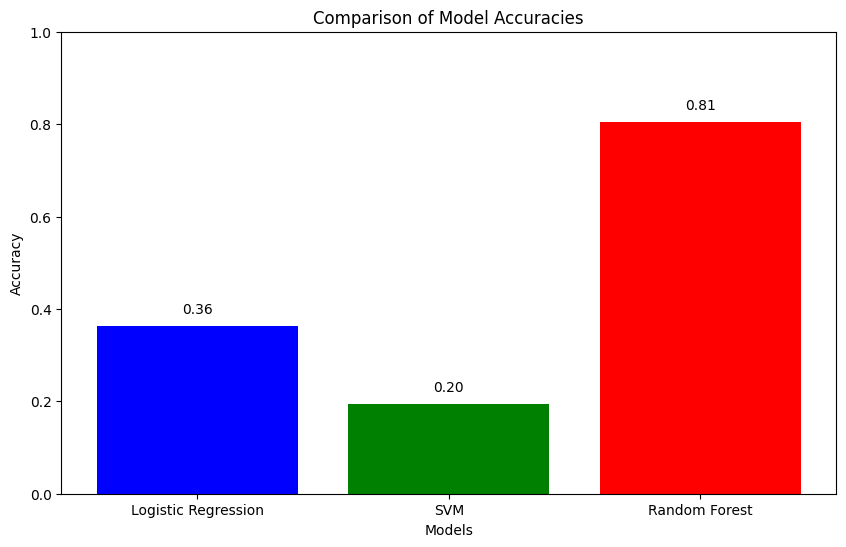

In [ ]:
import matplotlib.pyplot as plt

# Data to plot
models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracies = [accuracy_log_reg, accuracy_svm, accuracy_rf]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.show()


**Question**: An important point in medical imaging is the explicability. Can you find the most important and discriminative features ? If yes, how ? Hint: random forest has a very interesting function...  

In [ ]:
importances = rf.feature_importances_
feature_columns = ['f1', 'f2','f5','f6','f7','f8','f9','f10','f21','f22','f23','age','sex']
# To make it easier to interpret, you can put these importances into a DataFrame
feature_importances = pd.DataFrame({'feature': feature_columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances[:5])

  feature  importance
0      f1    0.119593
1      f2    0.115331
5      f8    0.113210
6      f9    0.109458
7     f10    0.107496


The features that contribute most significantly to the model's performance are (f1, f2), which represent the asymmetry of the lesion's shape, and f8, which is the 25th percentile of the ANOVA analysis. This is closely followed by the 50th and 75th percentiles of the ANOVA analysis. From these insights, we can conclude that the shape of the lesion plays a pivotal role in determining its type. The prominence of shape-related features in the model's decision-making process underscores their importance in the effective identification and classification of skin lesions. This finding aligns with medical understanding, as the asymmetry and irregularity in the shape of lesions are key indicators in diagnosing skin conditions, particularly in the context of melanoma detection.

In [ ]:
X_train.to_csv('myX_train.csv')
X_test.to_csv('myX_test.csv')

Now you should have a final ML model with a generalization performance on the Test Set.

**Question**: Are you satisfied ? How long did it take to compute and evaluate the manually engineered features ? If you are not satisfied, what are the main problems ? Besides Deep Learning, could you do something to improve the results (if you had more time?)


The Random Forest model alone yielded satisfactory results with accurecy of 0.81 on the test set, even without any additional fine-tuning. All models were trained using 13 features derived from the images. The comprehensive process of feature engineering, which included reviewing relevant papers and implementing the features, spanned over seven hours across several days. A significant challenge I faced was in assembling the X_test and X_train datasets. Extracting all features across the complete dataset required over two hours of processing time on a GPU. To enhance my results, I would consider fine-tuning the classifiers, perhaps using grid search, especially since a validation set is available. Another strategy to address class imbalance involves generating synthetic data for the melanoma class, which is significantly underrepresented compared to the other class. Alternatively, training the model on a subset of the training data with a less pronounced class imbalance might be beneficial. Future efforts will also include further research into best practices for feature engineering and organization. Although efforts were made to optimize computation, for instance by reducing image rotations to eight instead of the 36 suggested in the literature for asymmetry features (both shape and color), there is still room for improvement in this area.